In [1]:
import tweepy
import pickle
from tweepy import OAuthHandler

In [2]:
from twitter_creds import API_KEY, API_SECRET, ACCESS_TOKEN, ACCESS_SECRET
api_key = API_KEY
api_secret = API_SECRET
access_token = ACCESS_TOKEN
access_secret = ACCESS_SECRET

In [3]:
# Initialize tokens
auth = OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_secret)
args = ['covid']
api = tweepy.API(auth, timeout=10)

In [4]:
# Fetch tweets from a major hub radius
# https://www.latlong.net/
# Dallas = '32.777981,-96.796211,100mi'
# Houston = '29.760427,-95.369804,100mi'
# Chicago = '41.892822,-87.645954,100mi'
# Los Angeles = '34.052235,-118.243683,100mi'
# New York = '40.712776,-74.005974,100mi'

list_tweets = []
query = args[0]
if len(args) == 1:
#     for status in tweepy.Cursor(api.search, q=query+' -filter:retweets', 
#                                 lang='en', result_type='recent',
#                                 geocode='29.760427,-95.369804,50mi').items(100):
    for status in tweepy.Cursor(api.search, q=query, include_rts=False, include_entities=True, 
                            lang='en', result_type='recent',
                            geocode='40.712776,-74.005974,50mi').items(500):
        
        list_tweets.append(status.text)
        
# print(list_tweets)

In [5]:
with open('classifier.pickle', 'rb') as f:
    classifier = pickle.load(f)
    
with open('tfidfmodel.pickle', 'rb') as f:
    tfidf = pickle.load(f)

In [6]:
import re
from contractions import contractions

def clean(s):
    # Replace contractions
    if True:
        s = s.split()
        clean_s = []
        for word in s:
            if word in contractions:
                clean_s.append(contractions[word])
            else:
                clean_s.append(word)
                
        s = ' '.join(clean_s)
        
    s = re.sub(r'<.*?>|[^a-zA-Z. ]', '', s)
    
    return s

In [7]:
import pandas as pd

label_1 = label_0 = 0
sentences = []

for tweet in list_tweets:
    tweet = clean(tweet)
    sentence = classifier.predict(tfidf.transform([tweet]).toarray())
    sentences.append(sentence)
    if sentence[0] == 1:
        label_1 += 1
    else:
        label_0 += 1
        
df = pd.DataFrame({'Tweet': list_tweets, 'Label': sentences})
df.head()

,Tweet,Label
0,RT @SenSchumer: Wear a mask.\nWear a mask.\nWe...,[0]
1,"RT @stengel: Please, don't get distracted by t...",[0]
2,"RT @danielsgoldman: In other words, the politi...",[0]
3,RT @sarahcpr: White House releases guidance on...,[0]
4,RT @sarahcpr: White House releases guidance on...,[0]


Label 1 totals: 162, Label 0 totals: 338


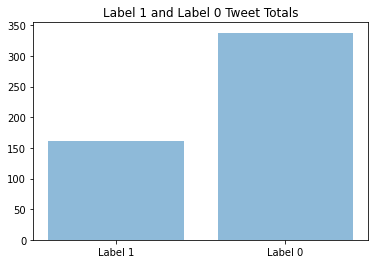

In [8]:
import matplotlib.pyplot as plt
import numpy as np

print(f'Label 1 totals: {label_1}, Label 0 totals: {label_0}')
objects = ['Label 1', 'Label 0']
y_1 = np.arange(len(objects))
plt.bar(y_1, [label_1, label_0], alpha=0.5)
plt.xticks(y_1, objects)
plt.title('Label 1 and Label 0 Tweet Totals')
plt.show()

In [9]:
print('Samples of Label 1')
print([t for t in df.Tweet[df.Label == 1].head()])
print()
print('Samples of Label 0')
# print(df.Tweet[df.Label == 0].iloc[0])
print([t for t in df.Tweet[df.Label == 0].head()])

Samples of Label 1
["RT @DrTomFrieden: This is atrocious. What good is a test for Covid if it comes back after the patient's  infecious period AND likely infect…", 'RT @WallStCopywrite: #Accelerating #digital #transformation in the #Covid19 era\n\n#finance #money #business #entrepreneur #investment #succe…', 'RT @ArmyBratt68: I watched a news story last night that showed several private FL labs were only reporting positive COVID-19 results and no…', "RT @kimlockhartga: COVID is sneaky and cruel. My cousin's husband tested positive on Sat. He felt fine. Rushed to hospital on Sun. In coma…", 'Tech expert, Jennifer Jolly, is here to share some apps, gadgets, and tips to help you travel as safely as possible… https://t.co/5brNcOmxiF']

Samples of Label 0
['RT @SenSchumer: Wear a mask.\nWear a mask.\nWear a mask.\nWear a mask.\nWear a mask.\n\nWe can get COVID-19 much more under control if we all wea…', "RT @stengel: Please, don't get distracted by the White House soap opera. That's what th